# 欠拟合 VS 过拟合

欠拟合： 模型无法得到较低的训练误差（training error）

过拟合： 模型的训练误差远小于它在测试集上的泛化误差（generalization error）

影响模型过拟合和欠拟合的两个主要因素：
* 模型复杂度
* 训练集大小

In [1]:
import torch
from torch import nn
from torch.utils import data
import numpy as np
import sys
import utils as d2l

## dataset

In [2]:
n_train = 256
n_test = 256
t_w = [1.2, -3.4, 5.6]
t_b = 5

# linear feature
features = torch.randn((n_train + n_test, 1)) 
# unlinear feature
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1) 
# ture labels
labels = (t_w[0] * poly_features[:, 0] + t_w[1] * poly_features[:, 1] + t_w[2] * poly_features[:, 2] + t_b)
# add noise
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [3]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

## train

In [4]:
num_epochs = 100
# batch_size = 128
lr = 0.01
loss = nn.MSELoss()

def fit_and_plot(train_features, train_labels, test_features, test_labels):
    
    # train generator
    batch_size = min(32, train_features.shape[0])
    
    dataset = data.TensorDataset(train_features, train_labels)
    train_generator = data.DataLoader(dataset, batch_size, shuffle=True)
    
    # net
    net = nn.Linear(train_features.shape[-1], 1)
    
    # potimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    
    train_loss, test_loss = [], []
    
    # train step
    for _ in range(num_epochs):
        
        # update model
        for x, y in train_generator:
            
            pred_y = net(x)
            # loss
            l = loss(pred_y, y.view(-1, 1))
            
            # grad clearing
            optimizer.zero_grad()
            
            # backward
            l.backward()
            
            # execute grad update
            optimizer.step()
            
        # computer loss
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        
        # record loss of per epoch
        train_loss.append(loss(net(train_features), train_labels).item())
        test_loss.append(loss(net(test_features), test_labels).item())    
        
    print('final epoch: train loss', train_loss[-1], 'test loss', test_loss[-1])
    semilogy(range(1, num_epochs + 1), train_loss, 'epochs', 'loss', range(1, num_epochs + 1), 
             test_loss, ['train', 'test'])
    print('weight: {}  bias {}'.format(net.weight.data, net.bias.data))
    


###  正常

输入特征为：三阶指数特征

输入标签为：三阶多项式的标签

模型： 三阶非线性模型

训练数据：全部

final epoch: train loss 0.00010088005365105346 test loss 0.0001283016026718542
weight: tensor([[ 1.1949, -3.3988,  5.6009]])  bias tensor([4.9984])


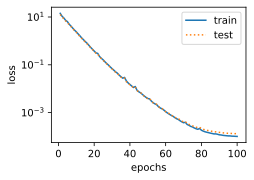

In [5]:
fit_and_plot(poly_features[:n_train, :], labels[:n_train], poly_features[n_train:, :], labels[n_train:])

### 欠拟合

输入特征为：一阶特征

输入标签为：三阶多项式的标签

模型： 一线性模型

训练数据：全部


final epoch: train loss 334.624267578125 test loss 171.98089599609375
weight: tensor([[21.3838]])  bias tensor([0.2702])


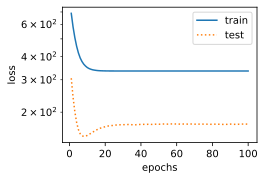

In [6]:
fit_and_plot(features[:n_train, :], labels[:n_train], features[n_train:, :], labels[n_train:])

### 过拟合

输入特征为：三阶指数特征

输入标签为：三阶多项式的标签

模型： 三阶非线性模型

训练数据： 少量

final epoch: train loss 2.597607135772705 test loss 4.242151737213135
weight: tensor([[ 1.6210, -2.5926,  5.3790]])  bias tensor([2.7049])


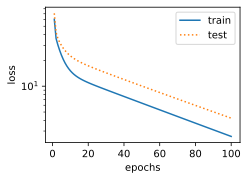

In [7]:
fit_and_plot(poly_features[:10, :], labels[:10], poly_features[10:, :], labels[10:])